In [4]:
from dataloader import load_cora
import torch

# Load data
# adj, features, labels, idx_train, idx_val, idx_test = load_cora()
tmp = torch.load('../data/cora/preprocessed.pth')
adj_i, adj_v, adj_s, features, labels, idx_train, idx_val, idx_test = tmp
adj = torch.sparse.FloatTensor(adj_i, adj_v, adj_s)

# Load pretrained
pretrained = torch.load('save/model-val-0.8233.pth')
pretrained_weights = torch.cat((pretrained['gcns.0.weight'].reshape(-1),
                                pretrained['gcns.0.bias'].reshape(-1),
                                pretrained['gcns.1.weight'].reshape(-1),
                                pretrained['gcns.1.bias'].reshape(-1),),dim=0)
Check: pretrained_weights[0:22928].reshape(1433, 16) - pretrained['gcns.0.weight']
pretrained_init = torch.cat((pretrained_weights, -0.5 * torch.ones_like(pretrained_weights)))

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.distributions.normal import Normal
from torch.autograd import Variable

class Counter(object):
    def __init__(self, name):
        self.name = name
        self.values = []
        self.total = 0.0
        self.count = 0.0
        
    def push(self, x):
        self.values.append(x)
        self.total += x
        self.count += 1
        
    def avg(self):
        return self.total / self.count
    
    def rolling_avg(self, n):
        return sum(self.values[-n:]) / n
    
def softplus(rho):
    # convert from rho -> sigma
    return torch.log(1 + torch.exp(rho))     

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_weights = 0
        self.use_bias = bias
        
        self.weight = None # Parameter(torch.FloatTensor(in_features, out_features))
        self.num_weights += in_features * out_features
        
        if self.use_bias:
            self.bias = None # Parameter(torch.FloatTensor(out_features))
            self.num_weights += out_features
        else:
            self.register_parameter('bias', None)
                    
    def init_weights(self, weights):
        self.weight = weights[:self.in_features * self.out_features].reshape(self.in_features, self.out_features)
        if self.use_bias:
            self.bias = weights[self.in_features * self.out_features:]
            
        # This could be a problem! 
        
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.layers = [self.gc1, self.gc2]
        self.num_weights = sum(layer.num_weights for layer in self.layers)
        self.dropout = dropout
        
    def kernel(self, x):
        ## Standard RBF kernel: x -> exp(-x*x)
        return torch.nn.functional.relu(x) # torch.exp(-x*x)
    
    def init_params(self):
        return torch.randn(self.num_weights * 2, requires_grad=True) # stored as [mu1, mu2, rho1, rho2]
    
    def init_weights(self, var_params):
        ## Returns log_prob of weights, prior_prob of weights
        w_dist = Normal(var_params[:self.num_weights], softplus(var_params[self.num_weights:]))
        p_dist = Normal(torch.zeros(self.num_weights), torch.ones(self.num_weights) * 5)
        weights = w_dist.rsample() # var_params[:self.num_weights] # w_dist.rsample()
        
        counter = 0
        for layer in self.layers:
            layer.init_weights(weights[counter:counter+layer.num_weights])
            counter += layer.num_weights
        
        return w_dist.log_prob(weights), p_dist.log_prob(weights)
        
    def forward(self, x, adj):
        x = self.kernel(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [6]:
def accuracy(pred, true, idx):
    ## Outputs accuracy on given index
    assert(len(pred) == len(true))
    return np.sum((pred == true)[idx]) / len(true[idx])

def bbb(adj, features, labels, idx_train, idx_val, model, params, epochs=140, samples=10, seed=42):
    torch.manual_seed(seed)
    
    for i in range(epochs):
        if i % 10 == 0:
            val(adj, features, labels, idx_train, idx_val, model, params)
            model.train()
        
        ## Clear gradients
        optimizer.zero_grad()
        # print(params.grad)
        
        total_ll = 0.0
        total_wl = 0.0
        total_wp = 0.0
        
        for j in range(samples):
                        
            ## Init weights
            weight_ll, weight_prior = model.init_weights(params)
            total_wl += weight_ll.sum() / model.num_weights
            total_wp += weight_prior.sum() / model.num_weights

            ## Forward pass, compute log_likelihood
            pred = model(features, adj)
            model_ll = - F.nll_loss(pred[idx_train], labels[idx_train])
            total_ll += model_ll

            ## Compute loss
            ELBO = - model_ll - (weight_prior.sum() - weight_ll.sum()) / model.num_weights
            # Why divide by weights twice? 

            ## Compute gradients
            ELBO.backward()
        
        if i % 5 == 0:
            total_ELBO = total_ll + total_wp - total_wl
            print("Train :: Epoch {0:d} | ELBO: {1:.3f} | LL: {2:.3f} ".format(i + 1, total_ELBO / samples, total_ll / samples))
        
        ## Update parameters
        # print("OLD", params[:5])
        optimizer.step()    
        # print("NEW", params[:5])
        
def val(adj, features, labels, idx_train, idx_val, model, params, samples=300, seed=42):
    torch.manual_seed(seed)
    model.eval() # This could be a problem
    
    train_ll = 0.0
    val_ll = 0.0
    train_acc = 0.0
    val_acc = 0.0

    for j in range(samples):
        ## Forward pass
        _ = model.init_weights(params)
        pred = model(features, adj)
        y_hat = torch.argmax(pred, dim=1)
        
        ## collect log_likelihood statistics
        train_ll += - F.nll_loss(pred[idx_train], labels[idx_train])
        val_ll += - F.nll_loss(pred[idx_val], labels[idx_val])
        
        ## collect accuracy statistics
        train_acc += accuracy(y_hat.numpy(), labels.numpy(), idx_train)
        val_acc += accuracy(y_hat.detach().numpy(), labels.numpy(), idx_val)
            
    print("Val   :: Train LL: {0:.3f} | Val LL: {1:.3f} | Train Accuracy: {2:.3f} | Val Accuracy: {3:.3f} ".format(
        train_ll / samples, val_ll / samples, train_acc / samples, val_acc / samples))
        
model = GCN(nfeat=features.shape[1],
            nhid=16,
            nclass=labels.max().item() + 1,
            dropout=0.5)

var_params = model.init_params()
var_params.data = pretrained_init.data.clone().cpu()
# var_params.data.uniform_(0,0.01)
optimizer = optim.Adam([var_params], lr=2e-2) # weight_decay=args.weight_decay

bbb(adj, features, labels, idx_train, idx_val, model, var_params, samples=20)
val(adj, features, labels, idx_train, idx_val, model, var_params, samples=1)

Val   :: Train LL: -1.838 | Val LL: -2.230 | Train Accuracy: 0.408 | Val Accuracy: 0.335 
Train :: Epoch 1 | ELBO: -4.076 | LL: -2.216 


KeyboardInterrupt: 

[[ 0  0  0 ...  0 19  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 19  0  0]
 ...
 [ 0 19  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 [ 0  0  0 ...  0 19  0]] [5 3 4 ... 1 2 5] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05]


/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


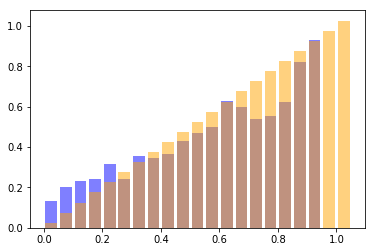

ECE 0.02467028909052544


In [23]:
model.eval()
model.init_weights(var_params)
probs = model(features, adj).detach().numpy()
probs = np.exp(probs)
# labels = labels.numpy()
bins = np.arange(0, 1.1, 0.05)
inds = np.digitize(probs, bins) - 1

print(inds, labels, bins)

def ECE(inds, labels, bins):
    ## Produce Plot
    labels_onehot = torch.zeros(7, len(labels)).scatter_(0,torch.LongTensor([labels]),1).numpy().T
    bin_avgs = (bins[:-1] + bins[1:]) / 2

    ece = 0
    true_probs = []
    for idx, b in enumerate(bins):
        num = np.sum(inds == idx)
        # print(labels_onehot, inds == idx, 'value', labels_onehot[inds == idx])
        correct = np.sum(labels_onehot[inds == idx])
        true_probs.append(correct/num)
        if num > 0:
            ece += num / (7 * len(labels)) * np.abs(bin_avgs[idx] - correct/num)     
            # print(num / (7 * len(labels)) * np.abs(bin_avgs[idx] - correct/num))
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.bar(bin_avgs, true_probs[1:], width=bins[1]-bins[0]-0.01, color='blue', alpha=0.5) #true
    plt.bar(bin_avgs, bin_avgs, width=bins[1]-bins[0]-0.01, color='orange', alpha=0.5) #ideal
    plt.show()

    print("ECE", ece)
    
ECE(inds, labels, bins) #whole set

/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


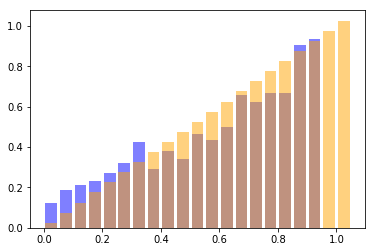

ECE 0.0218357142857143


In [24]:
ECE(inds[idx_test], labels[idx_test], bins)

In [ ]:
def test(adj, features, labels, idx_train, idx_val, idx_test, model, params, samples=1000, seed=42):
    torch.manual_seed(seed)
    
    train_ll = 0.0
    val_ll = 0.0
    test_ll = 0.0
    train_acc = 0.0
    val_acc = 0.0
    test_acc = 0.0

    for j in range(samples):
        ## Forward pass
        _ = model.init_weights(params)
        pred = model(features, adj)
        y_hat = torch.argmax(pred, dim=1)
        
        ## collect log_likelihood statistics
        train_ll += - F.nll_loss(pred[idx_train], labels[idx_train])
        val_ll += - F.nll_loss(pred[idx_val], labels[idx_val])
        test_ll += - F.nll_loss(pred[idx_test], labels[idx_test])
        
        ## collect accuracy statistics
        train_acc += accuracy(y_hat.numpy(), labels.numpy(), idx_train)
        val_acc += accuracy(y_hat.numpy(), labels.numpy(), idx_val)
        test_acc += accuracy(y_hat.numpy(), labels.numpy(), idx_test)
            
            
    print("Test :: Train LL: {0:.3f} | Val LL: {1:.3f} | Test LL: {2:.3f} ".format(
        train_ll / samples, val_ll / samples, test_ll / samples))
    print("Test :: Train Acc: {0:.3f} | Val Acc: {1:.3f} | Test Acc: {2:.3f} ".format(
        train_acc / samples, val_acc / samples, test_acc / samples))
    
test(adj, features, labels, idx_train, idx_val, idx_test, model, var_params)


In [34]:
pred = None

for j in range(1000):
    ## Forward pass
    _ = model.init_weights(var_params)
    if pred is not None:
        pred += torch.exp(model(features, adj))
    else:
        pred = torch.exp(model(features, adj))

In [78]:
pred = pred[idx_test]
labels = labels[idx_test]
guess = torch.argmax(pred, dim=1)
correct = guess == labels
wrong = guess != labels

In [79]:
entropy = - torch.sum(pred / 1000 * torch.log(pred / 1000), dim=1)
entropy

tensor([1.3603, 1.2366, 0.7163, 0.9059, 1.6553, 0.8282, 1.2415, 0.4502, 1.6636,
        1.8381, 0.3000, 1.0848, 0.6153, 0.2018, 1.0080, 0.3347, 0.9520, 1.4775,
        1.1042, 0.1209, 1.6844, 1.4668, 1.0457, 1.5584, 1.6741, 1.0121, 0.4431,
        0.4373, 1.5516, 1.6314, 1.3661, 1.2409, 0.4992, 0.3843, 1.0915, 0.3969,
        0.2143, 0.9615, 0.9302, 0.3421, 1.2179, 0.3613, 0.7717, 1.4395, 0.0963,
        1.2443, 1.4173, 1.5498, 0.3102, 0.3460, 1.3068, 1.6502, 0.0806, 0.3665,
        0.1731, 0.8521, 0.6557, 1.1187, 0.7254, 0.4201, 1.5736, 0.2589, 0.5086,
        1.2704, 0.3669, 0.1868, 0.2815, 0.5458, 1.6864, 0.5012, 0.1060, 0.2724,
        0.6947, 0.7801, 0.8286, 0.3371, 0.0677, 0.5936, 0.8561, 0.4497, 0.5007,
        0.3303, 1.7694, 0.3361, 0.8834, 1.2275, 0.5014, 1.3169, 0.7456, 0.7288,
        1.6292, 0.5110, 0.5746, 0.9860, 0.7626, 0.3631, 1.5574, 1.0405, 1.3766,
        0.7371, 0.2833, 0.5042, 1.3460, 1.1541, 0.9515, 0.3335, 1.1740, 1.4945,
        0.2300, 1.1782, 0.4101, 0.3760, 

(array([ 4.,  1.,  0.,  0.,  4.,  2.,  0.,  2.,  7.,  4., 11.,  7., 10.,
         6., 18., 16., 20., 23., 25., 17.]),
 array([0.2469458 , 0.32759136, 0.40823692, 0.48888248, 0.56952804,
        0.6501736 , 0.73081917, 0.8114647 , 0.8921103 , 0.97275585,
        1.0534015 , 1.134047  , 1.2146926 , 1.2953382 , 1.3759837 ,
        1.4566293 , 1.5372748 , 1.6179204 , 1.698566  , 1.7792115 ,
        1.8598571 ], dtype=float32),
 <a list of 20 Patch objects>)

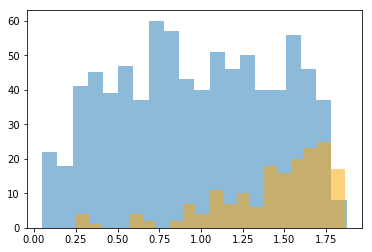

In [92]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.hist(entropy[correct].data.numpy(), alpha=0.5, bins=20)
plt.hist(entropy[wrong].data.numpy(), color='orange', alpha=0.5, bins=20)

In [82]:
sum(correct) + sum(wrong)

tensor(232, dtype=torch.uint8)

In [90]:
entropy.shape

torch.Size([1000])

In [3]:
adj.shape, features.shape, labels.shape

(torch.Size([2708, 2708]), torch.Size([2708, 1433]), torch.Size([2708]))

In [7]:
import time
from dataloader import load_adv_data
import scipy.sparse as sp

def accuracy(pred, true, idx):
    ## Outputs accuracy on given index
    assert(len(pred) == len(true))
    return np.sum((pred == true)[idx]) / len(true[idx])

class Counter:
    def __init__(self, types):
        self.values = {}
        for t in types:
            self.values[t] = []
            
    def avg(self, t):
        return np.mean(self.values[t])
    
    def update(self, xs, types):
        for i, x in enumerate(xs):
            self.values[types[i]].append(x)
            
    def print_all(self):
        for t in self.values.keys():
            print(t, self.avg(t))

def adv_train(nodes):
    start = time.time()
    counts = ['train_acc', 'val_acc', 'test_acc', 'adv_acc']
    results = Counter(counts)
    
    for node in nodes:
        model = GCN(nfeat=1433,
                    nhid=16,
                    nclass=7,
                    dropout=0.5)
        model.eval()
        params = model.init_params()
        optimizer = optimizer = optim.Adam([params], lr=2e-2, weight_decay=5e-4)
        
        adj, features, labels, idx_train, idx_val, idx_test = load_adv_data(node)
        
        bbb(adj, features, labels, optimizer, idx_train, idx_val, model, params, epochs=1000, samples=10, seed=42)
            
        _ = model.init_weights(params)
        pred = model(features, adj)
        pred = torch.argmax(pred, dim=1).numpy()
        print(pred)
        
        train_acc = accuracy(pred, labels.numpy(), idx_train)
        val_acc = accuracy(pred, labels.numpy(), idx_val)
        test_acc = accuracy(pred, labels.numpy(), idx_test)
        adv_acc = accuracy(pred, labels.numpy(), [node])
        results.update([train_acc, val_acc, test_acc, adv_acc], counts)
    
    end = time.time()  
    print("Time Taken", end-start)
    results.print_all()
    return results

adv_train(idx_test[:50])

Loading cora dataset...


NameError: name 'encode_onehot' is not defined